In [55]:
import re
import pandas as pd
#from sklearn.model_selection import train_test_split

# Load the CSV file into a DataFrame
short = pd.read_csv('high-charge-density22.csv')
short['Class'] = 1

pos = short[
    (short['Sequence'].str.len() > 6) &
    (short['Sequence'].str.len() < 40)
]

pos = pos.sample(n=min(4526, len(pos)), random_state=40)
pos

,Sequence,Class
1602,FWRRYKKVKKYRRWF,1
3413,VDKPPYLPRVRPPRRIYNR,1
596,WWKRWKRIRRIFMMV,1
913,LLCKLKCKLKL,1
2492,KLKAGLAKWKAGLAKLKAGLA,1
...,...,...
575,VQLRCRVCVIRK,1
1509,WRLWRLWRLWRLWRL,1
1381,LARFVLRILKYGFK,1
3620,VAKKLAKLAKKLAKLAL,1


In [56]:
import re
import pandas as pd
#from sklearn.model_selection import train_test_split

# Load the CSV file into a DataFrame
short = pd.read_csv('neg-high-charge-density22.csv')
short['Class'] = 0
neg = short[
    (short['Sequence'].str.len() > 6) &
    (short['Sequence'].str.len() < 40)
]
neg
# Display the result
neg

neg

,Sequence,Class
0,EREREKRFSFFKKNK,0
1,GRKRRQTSLTDFYHSKRRLVFCKRKP,0
2,ARRRRRHASTKLKRRRRRRRHGKKSHK,0
3,ARRRRRSSRPQRRRRRRRHGRRRRGRR,0
4,PRRRTRRASRPVRRRRPRRVSRRRRARRRR,0
...,...,...
4523,KSLSTGKSKSFFVRQTNKS,0
4524,KSKSFFVRQTKKS,0
4525,KSLSTGKSKSFFVRQTKKS,0
4526,FSSEKLKARKEKKSRKQAPY,0


In [57]:
concatenated_df = pd.concat([pos,neg], ignore_index=True)
concatenated_df = concatenated_df.drop_duplicates(subset='Sequence', keep=False)
concatenated_df

,Sequence,Class
0,FWRRYKKVKKYRRWF,1
1,VDKPPYLPRVRPPRRIYNR,1
2,WWKRWKRIRRIFMMV,1
3,LLCKLKCKLKL,1
4,KLKAGLAKWKAGLAKLKAGLA,1
...,...,...
9047,KSLSTGKSKSFFVRQTNKS,0
9048,KSKSFFVRQTKKS,0
9049,KSLSTGKSKSFFVRQTKKS,0
9050,FSSEKLKARKEKKSRKQAPY,0


In [58]:
import re
# Clean comma-separated sequences (take the first part)
concatenated_df['Sequence'] = concatenated_df['Sequence'].str.split(',').str[0]

# Remove spaces
concatenated_df['Sequence'] = concatenated_df['Sequence'].str.replace(' ', '', regex=False)

# Remove invalid amino acids
concatenated_df['Sequence'] = concatenated_df['Sequence'].apply(lambda x: re.sub(r'[^ACDEFGHIKLMNPQRSTVWY]', '', x))

#from sklearn.model_selection import train_test_split

# Remove sequences with issues
concatenated_df =concatenated_df[~concatenated_df['Sequence'].str.contains('[, ZBOUXJ ]')]

concatenated_df

,Sequence,Class
0,FWRRYKKVKKYRRWF,1
1,VDKPPYLPRVRPPRRIYNR,1
2,WWKRWKRIRRIFMMV,1
3,LLCKLKCKLKL,1
4,KLKAGLAKWKAGLAKLKAGLA,1
...,...,...
9047,KSLSTGKSKSFFVRQTNKS,0
9048,KSKSFFVRQTKKS,0
9049,KSLSTGKSKSFFVRQTKKS,0
9050,FSSEKLKARKEKKSRKQAPY,0


In [59]:
concatenated_df = concatenated_df.reset_index(drop=True)
concatenated_df

,Sequence,Class
0,FWRRYKKVKKYRRWF,1
1,VDKPPYLPRVRPPRRIYNR,1
2,WWKRWKRIRRIFMMV,1
3,LLCKLKCKLKL,1
4,KLKAGLAKWKAGLAKLKAGLA,1
...,...,...
9041,KSLSTGKSKSFFVRQTNKS,0
9042,KSKSFFVRQTKKS,0
9043,KSLSTGKSKSFFVRQTKKS,0
9044,FSSEKLKARKEKKSRKQAPY,0


In [ ]:
import requests
import os
import time
import pandas as pd

# Configuration
OUTPUT_DIR = "hd/"
SLEEP_TIME = 5  # Seconds between requests
MAX_RETRIES = 3  # Retry attempts for failed requests
START_INDEX = 0  # <-- Change here to resume

# Create the output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

def get_pdb_from_sequence(seq, out_file_path):
    """Get PDB structure from ESM Atlas API for a given amino acid sequence"""
    url = "https://api.esmatlas.com/foldSequence/v1/pdb/"
    headers = {
        "Content-Type": "text/plain"
    }

    # Sanitize sequence
    clean_seq = ''.join(filter(str.isalpha, seq)).upper()

    for attempt in range(MAX_RETRIES):
        try:
            response = requests.post(url, data=clean_seq, headers=headers, timeout=30)
            if response.ok:
                with open(out_file_path, "w") as f:
                    f.write(response.text)
                return True
            else:
                print(f"Attempt {attempt + 1} failed for {clean_seq[:10]}... "
                      f"Status: {response.status_code}, Response: {response.text[:100]}")
                if response.status_code == 429:
                    time.sleep(SLEEP_TIME * (attempt + 2))  # Exponential backoff
        except Exception as e:
            print(f"Attempt {attempt + 1} error: {str(e)}")
            time.sleep(SLEEP_TIME)

    return False

# Initialize PDB_File column if missing
if 'PDB_File' not in concatenated_df.columns:
    concatenated_df['PDB_File'] = [None] * len(concatenated_df)

# Process each sequence from START_INDEX onward
for idx in range(START_INDEX, len(concatenated_df)):
    seq = concatenated_df.at[idx, 'Sequence']
    filename = f"peptide_{idx}.pdb"
    file_path = os.path.join(OUTPUT_DIR, filename)

    print(f"Processing sequence {idx + 1}/{len(concatenated_df)}: {seq[:15]}...")

 )
    if os.path.exists(file_path):
        print(f"Already exists: {file_path}")
        concatenated_df.at[idx, 'PDB_File'] = file_path
        continue

    success = get_pdb_from_sequence(seq, file_path)
    if success:
        print(f"Successfully saved: {file_path}")
        concatenated_df.at[idx, 'PDB_File'] = file_path
    else:
        print(f"Failed to get PDB for index {idx}")
        concatenated_df.at[idx, 'PDB_File'] = None

    time.sleep(SLEEP_TIME)




In [60]:
import os

OUTPUT_DIR = "hd//"
existing_files = os.listdir(OUTPUT_DIR)

for file in existing_files:
    if file.endswith(".pdb") and file.startswith("peptide_"):
        try:
            idx = int(file.replace("peptide_", "").replace(".pdb", ""))
            file_path = os.path.join(OUTPUT_DIR, file)
            if 0 <= idx < len(concatenated_df):
                concatenated_df.at[idx, 'PDB_File'] = file_path
        except ValueError:
            continue  # In case there's a filename that doesn't match the pattern


concatenated_df.to_csv("peptides_with_pdb_paths_fixed.csv", index=False)
print("✅ PDB_File column updated from existing files.")
concatenated_df

✅ PDB_File column updated from existing files.


,Sequence,Class,PDB_File
0,FWRRYKKVKKYRRWF,1,hd//peptide_0.pdb
1,VDKPPYLPRVRPPRRIYNR,1,hd//peptide_1.pdb
2,WWKRWKRIRRIFMMV,1,hd//peptide_2.pdb
3,LLCKLKCKLKL,1,hd//peptide_3.pdb
4,KLKAGLAKWKAGLAKLKAGLA,1,hd//peptide_4.pdb
...,...,...,...
9041,KSLSTGKSKSFFVRQTNKS,0,hd//peptide_9041.pdb
9042,KSKSFFVRQTKKS,0,hd//peptide_9042.pdb
9043,KSLSTGKSKSFFVRQTKKS,0,hd//peptide_9043.pdb
9044,FSSEKLKARKEKKSRKQAPY,0,hd//peptide_9044.pdb


In [61]:
from Bio.PDB import PDBParser, DSSP
import pandas as pd
import numpy as np
import os

# Path to folder containing PDB files
pdb_directory = "hd/./"  # Adjust if needed

# Initialize DSSP feature columns
dssp_columns = ['Mean_RSA', 'Mean_Phi', 'Mean_Psi']
for col in dssp_columns:
    concatenated_df[col] = np.nan

parser = PDBParser(QUIET=True)

# Loop to calculate RSA, Phi, Psi features
for idx in concatenated_df.index:
    pdb_filename = f"peptide_{idx}.pdb"
    pdb_path = os.path.join(pdb_directory, pdb_filename)

    if not os.path.exists(pdb_path):
        print(f"File not found: {pdb_path}")
        continue

    try:
        structure = parser.get_structure(f"pep_{idx}", pdb_path)
        model = structure[0]
        dssp = DSSP(model, pdb_path)

        rsa_list = []
        phi_list = []
        psi_list = []

        for res in dssp:
            rsa = res[3]
            phi = res[4]
            psi = res[5]

            rsa_list.append(rsa)
            phi_list.append(phi)
            psi_list.append(psi)

        # Compute means
        concatenated_df.at[idx, 'Mean_RSA'] = np.mean(rsa_list) if rsa_list else np.nan
        concatenated_df.at[idx, 'Mean_Phi'] = np.mean(phi_list) if phi_list else np.nan
        concatenated_df.at[idx, 'Mean_Psi'] = np.mean(psi_list) if psi_list else np.nan

    except Exception as e:
        print(f"Error processing index {idx} - file: {pdb_path}: {e}")


In [62]:
from Bio.PDB import PDBParser, DSSP
import os

# Columns to store DSSP secondary structure percentages
helices = []
sheets = []
coils = []

parser = PDBParser()

for idx in concatenated_df.index:
    pdb_file = f"hd/peptide_{idx}.pdb"
    try:
        structure = parser.get_structure(f"pep_{idx}", pdb_file)
        model = structure[0]
        dssp = DSSP(model, pdb_file)
        
        ss_list = [dssp[key][2] for key in dssp.keys()]
        total = len(ss_list)
        
        helix_count = sum(s in "HGI" for s in ss_list)
        sheet_count = sum(s in "BE" for s in ss_list)
        coil_count  = sum(s in "ST " for s in ss_list)  # includes turn, bend, and loops
        
        helices.append(helix_count / total * 100)
        sheets.append(sheet_count / total * 100)
        coils.append(coil_count / total * 100)
    except Exception as e:
        print(f"Failed to process {pdb_file}: {e}")
        helices.append(None)
        sheets.append(None)
        coils.append(None)

# Add DSSP % columns to DataFrame
concatenated_df['%Helix'] = helices
concatenated_df['%Sheet'] = sheets
concatenated_df['%Coil'] = coils


In [63]:
import mdtraj as md
import pandas as pd
import numpy as np
import os

# Folder containing your PDBs
pdb_folder = 'hd/'

# Initialize columns
concatenated_df['RoG'] = np.nan
concatenated_df['SASA'] = np.nan
concatenated_df['Compactness'] = np.nan

# Loop through each peptide
for idx in concatenated_df.index:
    pdb_path = os.path.join(pdb_folder, f"peptide_{idx}.pdb")

    if not os.path.exists(pdb_path):
        print(f"Missing: {pdb_path}")
        continue

    try:
        traj = md.load(pdb_path)
        
        # Radius of Gyration (RoG)
        rog = md.compute_rg(traj)[0]
        concatenated_df.at[idx, 'RoG'] = rog

        # Solvent Accessible Surface Area (SASA)
        sasa = md.shrake_rupley(traj)[0].sum()
        concatenated_df.at[idx, 'SASA'] = sasa

        # Compactness = Mass / SASA (or optionally 1/SASA per atom)
        n_atoms = traj.n_atoms
        compactness = n_atoms / sasa if sasa > 0 else np.nan
        concatenated_df.at[idx, 'Compactness'] = compactness

    except Exception as e:
        print(f"Error at index {idx}: {e}")


In [64]:
import pandas as pd
import peptides



# Define the peptide descriptors you want to calculate
descriptors = [
    'frequencies',
    'aliphatic_index',
    'boman',
    'charge',
    'isoelectric_point',
    'hydrophobic_moment',
    'hydrophobicity',
    'instability_index',
    'mass_shift',
    'molecular_weight',
    'mz',
    'structural_class'
]

# Create a dictionary to store descriptor values
descriptor_values_dict = {}

# Iterate through each descriptor and calculate values for each sequence
for descriptor in descriptors:
    descriptor_values = []
    for sequence in cleaned_df['Sequence']:
        peptide = peptides.Peptide(sequence)
        value = getattr(peptide, descriptor)()
        descriptor_values.append(value)
    descriptor_values_dict[descriptor] = descriptor_values

# Create a new DataFrame using the descriptor values dictionary
descriptors = pd.DataFrame(descriptor_values_dict)

In [66]:
import pandas as pd


# containing dictionaries of amino acid frequencies

# Expand 'frequencies' column into separate columns
amino_acid_frequencies = pd.DataFrame(descriptors['frequencies'].tolist()).fillna(0)

# Combine the expanded DataFrame with the original DataFrame
descriptors_df = pd.concat([descriptors, amino_acid_frequencies], axis=1)

# Drop the original 'frequencies' column
descriptors_df.drop(columns=['frequencies'], inplace=True)

# Display the resulting DataFrame
descriptors_df


,aliphatic_index,boman,charge,isoelectric_point,hydrophobic_moment,hydrophobicity,instability_index,mass_shift,molecular_weight,mz,...,T,W,Y,V,O,U,B,Z,J,X
0,19.333333,4.500000,7.995090,12.130605,0.630528,-1.880000,100.013333,48.161032,2247.72584,1124.149951,...,0.000000,0.133333,0.133333,0.066667,0.0,0.0,0.0,0.0,0.0,0.0
1,71.578947,4.098421,4.996418,11.947735,0.606835,-1.436842,55.884211,36.120774,2392.83874,1196.695446,...,0.000000,0.000000,0.105263,0.105263,0.0,0.0,0.0,0.0,0.0,0.0
2,71.333333,2.815333,5.997381,12.984698,0.750688,-0.580000,127.253333,36.120774,2192.76624,1096.621661,...,0.000000,0.200000,0.000000,0.066667,0.0,0.0,0.0,0.0,0.0,0.0
3,177.272727,-0.450909,3.872855,10.348813,0.279752,0.763636,-29.500000,24.080516,1302.78624,708.943280,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,121.428571,-0.348095,5.996214,11.499626,0.357415,0.204762,-6.647619,36.120774,2136.69854,1068.690761,...,0.000000,0.047619,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9041,35.789474,2.925263,4.996801,11.997381,0.345357,-1.015789,15.226316,30.100645,2130.43194,1065.586916,...,0.105263,0.000000,0.000000,0.052632,0.0,0.0,0.0,0.0,0.0,0.0
9042,22.307692,3.494615,4.996801,11.997381,0.390433,-1.300000,24.046154,30.100645,1570.85534,785.956821,...,0.076923,0.000000,0.000000,0.076923,0.0,0.0,0.0,0.0,0.0,0.0
9043,35.789474,2.867895,5.996506,12.054553,0.390433,-1.036842,10.673684,36.120774,2144.50224,1072.612931,...,0.105263,0.000000,0.000000,0.052632,0.0,0.0,0.0,0.0,0.0,0.0
9044,29.500000,4.056000,5.998907,11.106017,0.396581,-1.900000,51.370000,48.161032,2409.81744,1205.189861,...,0.000000,0.000000,0.050000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [67]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem


# Create a new DataFrame to store the results
d4 = pd.DataFrame()

def calculate_tpsa(peptide_sequence):
    # Create a molecule object from the peptide sequence
    peptide_molecule = Chem.MolFromSequence(peptide_sequence)

    if peptide_molecule is not None:
        # Calculate TPSA using AllChem method
        tpsa = AllChem.CalcTPSA(peptide_molecule)

        return tpsa
    else:
        print(f"Invalid peptide sequence: {peptide_sequence}")
        return None

# Apply the function to the 'Sequence' column and create a new 'TPSA' column
#new_pos['Sequence'] = cleaned_df['Sequence']
d4['TPSA'] = cleaned_df['Sequence'].apply(calculate_tpsa)

# Display the new DataFrame with TPSA values
d4

,TPSA
0,894.44
1,999.54
2,817.73
3,458.40
4,817.23
...,...
9041,980.89
9042,702.51
9043,963.82
9044,1085.96


In [68]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, Crippen, Lipinski, Descriptors


# Create a new DataFrame to store the results
d6 = pd.DataFrame()

def calculate_descriptors(peptide_sequence):
    # Create a molecule object from the peptide sequence
    peptide_molecule = Chem.MolFromSequence(peptide_sequence)

    if peptide_molecule is not None:
        # Calculate various molecular descriptors
        heavy_atom_count = Descriptors.HeavyAtomCount(peptide_molecule)
        logp = Crippen.MolLogP(peptide_molecule)
        mol_logp = Crippen.MolLogP(peptide_molecule)
        # MolLogS calculation is not directly available in RDKit, consider using other methods/tools
        fraction_csp3 = Lipinski.FractionCSP3(peptide_molecule)
        bertz_ct = Descriptors.BertzCT(peptide_molecule)

        return heavy_atom_count, logp, mol_logp, fraction_csp3, bertz_ct
    else:
        print(f"Invalid peptide sequence: {peptide_sequence}")
        return None

# Apply the function to the 'Sequence' column and create new columns for descriptors
#new_pos['Sequence'] = cleaned_df['Sequence']
d6[['HeavyAtomCount', 'LogP', 'MolLogP', 'FractionCSP3', 'BertzCT']] = cleaned_df['Sequence'].apply(calculate_descriptors).apply(pd.Series)

# Display the new DataFrame with descriptor values
d6

,HeavyAtomCount,LogP,MolLogP,FractionCSP3,BertzCT
0,162.0,-1.75942,-1.75942,0.468468,6167.457349
1,170.0,-7.24805,-7.24805,0.651376,5790.862434
2,155.0,0.16568,0.16568,0.533333,5810.258002
3,89.0,-0.14760,-0.14760,0.816667,2181.007600
4,151.0,-4.16360,-4.16360,0.712871,4692.193883
...,...,...,...,...,...
9041,150.0,-14.41313,-14.41313,0.634409,4705.308666
9042,111.0,-8.24023,-8.24023,0.619718,3290.838106
9043,151.0,-13.15953,-13.15953,0.652632,4650.711363
9044,170.0,-11.33486,-11.33486,0.654206,5415.940777


In [69]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Lipinski, Descriptors


# Create a new DataFrame to store the results
d7 = pd.DataFrame()

def calculate_polarity(peptide_sequence):
    # Create a molecule object from the peptide sequence
    peptide_molecule = Chem.MolFromSequence(peptide_sequence)

    if peptide_molecule is not None:
        # Calculate descriptors related to polarity
        num_h_acceptors = Lipinski.NumHAcceptors(peptide_molecule)
        num_h_donors = Lipinski.NumHDonors(peptide_molecule)
        #polar_surface_area = Descriptors.TPSA(peptide_molecule)

        return num_h_acceptors, num_h_donors
    else:
        print(f"Invalid peptide sequence: {peptide_sequence}")
        return None

# Apply the function to the 'Sequence' column and create new columns for polarity descriptors
#new_pos['Sequence'] = cleaned_df['Sequence']
d7[['NumHAcceptors', 'NumHDonors',]] = cleaned_df['Sequence'].apply(calculate_polarity).apply(pd.Series)

# Display the new DataFrame with polarity descriptors
d7

,NumHAcceptors,NumHDonors
0,26,36
1,30,35
2,24,33
3,18,18
4,28,29
...,...,...
9041,34,36
9042,24,26
9043,34,36
9044,36,39


In [70]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Lipinski, Descriptors


df8 = pd.DataFrame()

def calculate_amino_acid_properties(peptide_sequence):
    ng_count = peptide_sequence.count('C(N)N')
    npa_count = peptide_sequence.count('C(N)C')
    nncaa_count = peptide_sequence.count('D') + peptide_sequence.count('E')

    return ng_count, npa_count, nncaa_count
# Apply the function to the 'Sequence' column and create new columns for amino acid properties
df8[['NG', 'NPA', 'NNCAA']] = cleaned_df['Sequence'].apply(calculate_amino_acid_properties).apply(pd.Series)

# Display the DataFrame with amino acid properties
df8

,NG,NPA,NNCAA
0,0,0,0
1,0,0,1
2,0,0,0
3,0,0,0
4,0,0,0
...,...,...,...
9041,0,0,0
9042,0,0,0
9043,0,0,0
9044,0,0,2


In [71]:
cleaned_df.reset_index(drop=True, inplace=True)
descriptors_df.reset_index(drop=True, inplace=True)
d4.reset_index(drop=True, inplace=True)
d6.reset_index(drop=True, inplace=True)
d7.reset_index(drop=True, inplace=True)
df8.reset_index(drop=True, inplace=True)

In [72]:
ll = pd.concat([cleaned_df,descriptors_df,d4,d6,d7,df8], axis=1)
ll = ll.fillna(0)
ll

,Sequence,Class,PDB_File,Mean_RSA,Mean_Phi,Mean_Psi,%Helix,%Sheet,%Coil,RoG,...,HeavyAtomCount,LogP,MolLogP,FractionCSP3,BertzCT,NumHAcceptors,NumHDonors,NG,NPA,NNCAA
0,FWRRYKKVKKYRRWF,1,hd//peptide_0.pdb,0.859582,-52.913333,47.360000,46.666667,0.0,20.000000,1.094001,...,162.0,-1.75942,-1.75942,0.468468,6167.457349,26,36,0,0,0
1,VDKPPYLPRVRPPRRIYNR,1,hd//peptide_1.pdb,0.865338,-25.389474,113.342105,0.000000,0.0,0.000000,1.451317,...,170.0,-7.24805,-7.24805,0.651376,5790.862434,30,35,0,0,1
2,WWKRWKRIRRIFMMV,1,hd//peptide_2.pdb,0.716046,-42.386667,-8.420000,80.000000,0.0,6.666667,0.808917,...,155.0,0.16568,0.16568,0.533333,5810.258002,24,33,0,0,0
3,LLCKLKCKLKL,1,hd//peptide_3.pdb,0.829469,-41.363636,32.109091,45.454545,0.0,18.181818,0.697707,...,89.0,-0.14760,-0.14760,0.816667,2181.007600,18,18,0,0,0
4,KLKAGLAKWKAGLAKLKAGLA,1,hd//peptide_4.pdb,0.702707,-41.447619,-23.457143,90.476190,0.0,0.000000,0.989981,...,151.0,-4.16360,-4.16360,0.712871,4692.193883,28,29,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9041,KSLSTGKSKSFFVRQTNKS,0,hd//peptide_9041.pdb,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.584088,...,150.0,-14.41313,-14.41313,0.634409,4705.308666,34,36,0,0,0
9042,KSKSFFVRQTKKS,0,hd//peptide_9042.pdb,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.071776,...,111.0,-8.24023,-8.24023,0.619718,3290.838106,24,26,0,0,0
9043,KSLSTGKSKSFFVRQTKKS,0,hd//peptide_9043.pdb,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.553086,...,151.0,-13.15953,-13.15953,0.652632,4650.711363,34,36,0,0,0
9044,FSSEKLKARKEKKSRKQAPY,0,hd//peptide_9044.pdb,0.000000,0.000000,0.000000,65.000000,0.0,15.000000,1.004550,...,170.0,-11.33486,-11.33486,0.654206,5415.940777,36,39,0,0,2


In [73]:
categorical_df = ll.copy()

# Convert the "structural_class" column to categorical
categorical_df['structural_class'] = categorical_df['structural_class'].astype('category')

# Assign categorical codes to the categories
categorical_df['structural_class'] = categorical_df['structural_class'].cat.codes


In [75]:
X = categorical_df.drop(['Class','Sequence','PDB_File'], axis=1)
X = X.fillna(0)
y = categorical_df['Class']
y=y.astype('int')

X.columns

Index(['Mean_RSA', 'Mean_Phi', 'Mean_Psi', '%Helix', '%Sheet', '%Coil', 'RoG',
       'SASA', 'Compactness', 'aliphatic_index', 'boman', 'charge',
       'isoelectric_point', 'hydrophobic_moment', 'hydrophobicity',
       'instability_index', 'mass_shift', 'molecular_weight', 'mz',
       'structural_class', 'A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I',
       'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V', 'O', 'U', 'B', 'Z',
       'J', 'X', 'TPSA', 'HeavyAtomCount', 'LogP', 'MolLogP', 'FractionCSP3',
       'BertzCT', 'NumHAcceptors', 'NumHDonors', 'NG', 'NPA', 'NNCAA'],
      dtype='object')

In [76]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd


scaler = MinMaxScaler()

# Apply Min-Max Normalization to all columns in X
X_normalized = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Display the normalized DataFrame
print("Normalized DataFrame (Min-Max Scaling):")
X_normalized

Normalized DataFrame (Min-Max Scaling):


,Mean_RSA,Mean_Phi,Mean_Psi,%Helix,%Sheet,%Coil,RoG,SASA,Compactness,aliphatic_index,...,HeavyAtomCount,LogP,MolLogP,FractionCSP3,BertzCT,NumHAcceptors,NumHDonors,NG,NPA,NNCAA
0,0.859582,0.081032,0.200503,0.493333,0.0,0.257143,0.222100,0.371131,0.432633,0.068162,...,0.417683,0.802631,0.802631,0.353852,0.419944,0.311475,0.325843,0.0,0.0,0.000000
1,0.865338,0.142289,0.369236,0.000000,0.0,0.000000,0.349360,0.422953,0.377288,0.252362,...,0.442073,0.683278,0.683278,0.677767,0.392405,0.377049,0.314607,0.0,0.0,0.111111
2,0.716046,0.104460,0.057860,0.845714,0.0,0.085714,0.120567,0.276635,0.634448,0.251496,...,0.396341,0.844493,0.844493,0.468722,0.393824,0.278689,0.292135,0.0,0.0,0.000000
3,0.829469,0.106737,0.161503,0.480519,0.0,0.233766,0.080959,0.173225,0.344607,0.625000,...,0.195122,0.837681,0.837681,0.970485,0.128430,0.180328,0.123596,0.0,0.0,0.000000
4,0.702707,0.106550,0.019406,0.956463,0.0,0.000000,0.185053,0.287363,0.567783,0.428114,...,0.384146,0.750351,0.750351,0.786671,0.312064,0.344262,0.247191,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9041,0.000000,0.198795,0.079392,0.000000,0.0,0.000000,0.396647,0.386860,0.320409,0.126181,...,0.381098,0.527469,0.527469,0.647719,0.313023,0.442623,0.325843,0.0,0.0,0.000000
9042,0.000000,0.198795,0.079392,0.000000,0.0,0.000000,0.214185,0.251872,0.328373,0.078649,...,0.262195,0.661702,0.661702,0.621704,0.209588,0.278689,0.213483,0.0,0.0,0.000000
9043,0.000000,0.198795,0.079392,0.000000,0.0,0.000000,0.385606,0.382228,0.336022,0.126181,...,0.384146,0.554729,0.554729,0.679991,0.309031,0.442623,0.325843,0.0,0.0,0.000000
9044,0.000000,0.198795,0.079392,0.687143,0.0,0.192857,0.190242,0.333326,0.582127,0.104006,...,0.442073,0.594408,0.594408,0.682778,0.364989,0.475410,0.359551,0.0,0.0,0.222222


In [77]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

In [78]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score

# Create the XGBoost Classifier
xgb_classifier = XGBClassifier(n_estimators=60, learning_rate=0.2, max_depth=2,random_state=42)

# Perform 10-fold cross-validation
cv_scores = cross_val_score(xgb_classifier, X_train, y_train, cv=10)

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())

# Fit the model on the entire training set
xgb_classifier.fit(X_train, y_train)

# Predictions on the training set
y_train_pred = xgb_classifier.predict(X_train)

# Calculate accuracy on the training set
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Train Accuracy:", train_accuracy)

# Predictions on the test set
y_test_pred = xgb_classifier.predict(X_test)

# Calculate accuracy on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)

# Calculate precision on the test set
precision = precision_score(y_test, y_test_pred)
print("Precision:", precision)

# Calculate sensitivity (recall) on the test set
recall = recall_score(y_test, y_test_pred)
print("Sensitivity (Recall):", recall)

# Calculate ROC AUC score on the test set
roc_auc = roc_auc_score(y_test, xgb_classifier.predict_proba(X_test)[:,1])
print("ROC AUC:", roc_auc)





Cross-Validation Scores: [0.91160221 0.9019337  0.89779006 0.90883978 0.91160221 0.91160221
 0.90318119 0.93360996 0.89488243 0.90594744]
Mean CV Accuracy: 0.9080991189258997
Train Accuracy: 0.9176340519624102
Test Accuracy: 0.912707182320442
Precision: 0.921875
Sensitivity (Recall): 0.9037199124726477
ROC AUC: 0.9676156123007189


In [79]:
import shap
import numpy as np
import pandas as pd

# Define feature names properly
if isinstance(X_train, pd.DataFrame):
    feature_names = X_train.columns.tolist()  # Extract feature names if X_train is a DataFrame
elif isinstance(X_train, np.ndarray):
    # Manually define feature names if using a NumPy array
    feature_names = [f'Feature_{i}' for i in range(X_train.shape[1])]

# Ensure X_train is a DataFrame with proper column names
if isinstance(X_train, np.ndarray):
    # Adjust feature_names if needed
    if len(feature_names) != X_train.shape[1]:
        feature_names = feature_names[:X_train.shape[1]]  # Adjust if too many
        feature_names.extend([f'Feature_{i}' for i in range(len(feature_names), X_train.shape[1])])  # Add if too few

    X_train = pd.DataFrame(X_train, columns=feature_names)

# Create a SHAP explainer
explainer = shap.Explainer(xgb_classifier)
shap_values = explainer(X_train)

# Get the SHAP values in a DataFrame with actual column names
shap_df = pd.DataFrame(shap_values.values, columns=feature_names)

# Calculate the mean absolute SHAP values for each feature
mean_shap_values = np.abs(shap_df).mean()

# Sort the features based on the mean absolute SHAP values
top_features = mean_shap_values.sort_values(ascending=False).head(6)

# Print the average SHAP values for the top 6 features
print("Average SHAP values for the top 6 features:")
print(top_features)

Average SHAP values for the top 6 features:
LogP                  0.928037
W                     0.456100
hydrophobic_moment    0.359886
S                     0.254309
E                     0.220359
N                     0.215876
dtype: float32


/tmp/ipykernel_276298/4170954092.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Mean SHAP Value', y='Feature', data=shap_df, palette='viridis')


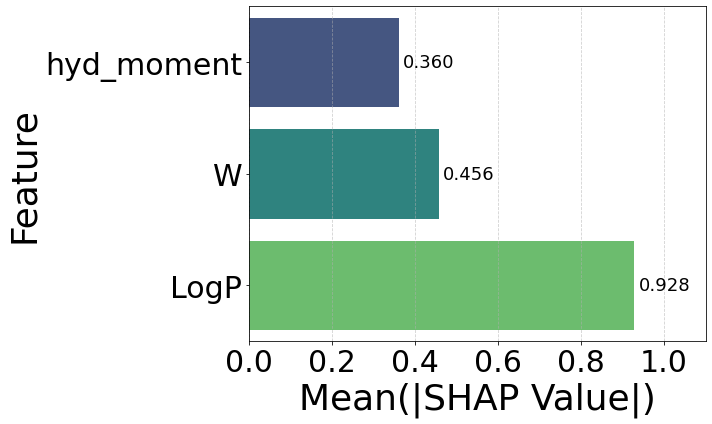

In [80]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# New SHAP values
shap_values = {
    'LogP': 0.928042,
    'W': 0.456139,
    'hyd_moment': 0.359772
}

# Convert to DataFrame and sort
shap_df = pd.DataFrame(shap_values.items(), columns=['Feature', 'Mean SHAP Value'])
shap_df = shap_df.sort_values(by='Mean SHAP Value', ascending=True)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Mean SHAP Value', y='Feature', data=shap_df, palette='viridis')

# Titles and labels
#plt.title('Top 3 Important Features (SHAP)', fontsize=20)
plt.xlabel('Mean(|SHAP Value|)', fontsize=36)
plt.ylabel('Feature', fontsize=36)

# Tick label size
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

# Grid and layout
plt.grid(True, axis='x', linestyle='--', alpha=0.6)

# Add SHAP value labels on bars
for i, (value, name) in enumerate(zip(shap_df['Mean SHAP Value'], shap_df['Feature'])):
    plt.text(value + 0.01, i, f'{value:.3f}', va='center', fontsize=18)

# Set x-axis limits
plt.xlim(0, 1.1)

# Grid
plt.grid(True, axis='x', linestyle='--', alpha=0.6)

plt.tight_layout()

plt.show()


In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score

# Create the Random Forest Classifier
rf_classifier = RandomForestClassifier(
    n_estimators=100,         # number of trees
    max_depth=2,              # adjust as needed
    random_state=42
)

# Perform 10-fold cross-validation
cv_scores = cross_val_score(rf_classifier, X_train, y_train, cv=10)

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())

# Fit the model on the entire training set
rf_classifier.fit(X_train, y_train)

# Predictions on the training set
y_train_pred = rf_classifier.predict(X_train)

# Calculate accuracy on the training set
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Train Accuracy:", train_accuracy)

# Predictions on the test set
y_test_pred = rf_classifier.predict(X_test)

# Calculate accuracy on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)

# Calculate precision on the test set
precision = precision_score(y_test, y_test_pred)
print("Precision:", precision)

# Calculate sensitivity (recall) on the test set
recall = recall_score(y_test, y_test_pred)
print("Sensitivity (Recall):", recall)

# Calculate ROC AUC score on the test set
roc_auc = roc_auc_score(y_test, rf_classifier.predict_proba(X_test)[:, 1])
print("ROC AUC:", roc_auc)


Cross-Validation Scores: [0.8218232  0.80110497 0.82458564 0.83839779 0.84254144 0.8218232
 0.79529737 0.81604426 0.80497925 0.82157676]
Mean CV Accuracy: 0.8188173891779952
Train Accuracy: 0.8217247097844113
Test Accuracy: 0.8209944751381215
Precision: 0.8277777777777777
Sensitivity (Recall): 0.8150984682713348
ROC AUC: 0.9062707584401376


In [50]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score

# Create the CatBoost Classifier
cat_classifier = CatBoostClassifier(
    iterations=60,       # number of boosting rounds
    learning_rate=0.1,    # step size
    depth=2,              # depth of trees
    verbose=0,            # suppress training output
    random_state=42
)

# Perform 10-fold cross-validation
cv_scores = cross_val_score(cat_classifier, X_train, y_train, cv=10)
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())

# Fit the model on the entire training set
cat_classifier.fit(X_train, y_train)

# Predictions on the training set
y_train_pred = cat_classifier.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Train Accuracy:", train_accuracy)

# Predictions on the test set
y_test_pred = cat_classifier.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)

# Precision, Recall, and ROC AUC
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, cat_classifier.predict_proba(X_test)[:, 1])

print("Precision:", precision)
print("Sensitivity (Recall):", recall)
print("ROC AUC:", roc_auc)


Cross-Validation Scores: [0.89364641 0.88259669 0.89088398 0.89364641 0.89364641 0.89640884
 0.88381743 0.90456432 0.87828492 0.8879668 ]
Mean CV Accuracy: 0.8905462200927688
Train Accuracy: 0.8967661691542289
Test Accuracy: 0.9005524861878453
Precision: 0.9132882882882883
Sensitivity (Recall): 0.887308533916849
ROC AUC: 0.9564579507267895


In [51]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score

# Create the Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(
    criterion='gini',        # or 'entropy'
    max_depth=2,             # control overfitting
    random_state=42
)

# Perform 10-fold cross-validation
cv_scores = cross_val_score(dt_classifier, X_train, y_train, cv=10)
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())

# Fit the model on the training set
dt_classifier.fit(X_train, y_train)

# Predictions on training set
y_train_pred = dt_classifier.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Train Accuracy:", train_accuracy)

# Predictions on test set
y_test_pred = dt_classifier.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)

# Precision, Recall, ROC AUC
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, dt_classifier.predict_proba(X_test)[:, 1])

print("Precision:", precision)
print("Sensitivity (Recall):", recall)
print("ROC AUC:", roc_auc)


Cross-Validation Scores: [0.8121547  0.79281768 0.80801105 0.80662983 0.7941989  0.78314917
 0.78699862 0.80359613 0.78008299 0.78146611]
Mean CV Accuracy: 0.7949105171056754
Train Accuracy: 0.7964344941956882
Test Accuracy: 0.7955801104972375
Precision: 0.7969432314410481
Sensitivity (Recall): 0.7986870897155361
ROC AUC: 0.8137394009846828


In [52]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score

# Create the Naive Bayes Classifier
nb_classifier = GaussianNB()

# Perform 10-fold cross-validation
cv_scores = cross_val_score(nb_classifier, X_train, y_train, cv=10)
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())

# Fit the model on the entire training set
nb_classifier.fit(X_train, y_train)

# Predictions on the training set
y_train_pred = nb_classifier.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Train Accuracy:", train_accuracy)

# Predictions on the test set
y_test_pred = nb_classifier.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)

# Precision, Recall, ROC AUC
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, nb_classifier.predict_proba(X_test)[:, 1])

print("Precision:", precision)
print("Sensitivity (Recall):", recall)
print("ROC AUC:", roc_auc)


Cross-Validation Scores: [0.84254144 0.81491713 0.84944751 0.85497238 0.85220994 0.83977901
 0.83679115 0.83540802 0.81742739 0.83540802]
Mean CV Accuracy: 0.8378901981461528
Train Accuracy: 0.8389994472084025
Test Accuracy: 0.8359116022099448
Precision: 0.8599766627771295
Sensitivity (Recall): 0.8063457330415755
ROC AUC: 0.9087611607142857
